In [3]:
!pip install fairlearn

In [4]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 17.6 MB/s eta 0:00:00


In [5]:

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate, demographic_parity_difference, equalized_odds_difference

import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [6]:

csv_path = Path('iris.csv')
if csv_path.exists():
    df = pd.read_csv(csv_path)
else:
    from sklearn.datasets import load_iris
    iris = load_iris(as_frame=True)
    df = iris.frame.rename(columns={
        'sepal length (cm)': 'sepal_length',
        'sepal width (cm)': 'sepal_width',
        'petal length (cm)': 'petal_length',
        'petal width (cm)': 'petal_width',
        'target': 'species'
    })
    # Map species index to names for readability
    target_names = dict(enumerate(iris.target_names))
    df['species'] = df['species'].map(target_names)

df.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa



## 2) Add a random binary `location` attribute

We assign values **0** or **1** at random (uniformly) to simulate a sensitive attribute.


In [7]:

n = len(df)
df['location'] = np.random.randint(0, 2, size=n)  # 0 or 1 at random
df['location'] = df['location'].astype(int)
df.head()


,sepal_length,sepal_width,petal_length,petal_width,species,location
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0



## 3) Train/validation split and preprocessing


In [9]:

feature_cols = [c for c in df.columns if c not in ['species']]
target_col = 'species'

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

numeric_cols = ['sepal_length','sepal_width','petal_length','petal_width']
all_numeric = numeric_cols + ['location']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), all_numeric),
    ],
    remainder='drop'
)

clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=RANDOM_STATE
)

pipe = Pipeline([('prep', preprocess),
                 ('clf', clf)])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.947

Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.92      0.92      0.92        13
   virginica       0.92      0.92      0.92        13

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38




## 4) Fairness evaluation with **Fairlearn**

We'll treat **`location`** as the **sensitive feature** and examine metrics like:
- **Selection rate** (how often the model predicts a given class)
- **True Positive Rate** (Recall for the positive class in one-vs-rest setting)
- **False Positive Rate**
- **Demographic Parity Difference**
- **Equalized Odds Difference**

For multiclass Iris, we'll focus on **class `virginica`** (one-vs-rest). We compute probabilities and convert to a binary prediction for `virginica` vs. not-virginica.


In [10]:


is_virginica = (y_test == 'virginica').astype(int)


proba = pipe.predict_proba(X_test)

class_index = list(pipe.named_steps['clf'].classes_).index('virginica')
virginica_proba = proba[:, class_index]


virginica_pred = (virginica_proba >= 0.5).astype(int)


sensitive_feature = X_test['location']


metrics = {
    'selection_rate': selection_rate,
    'tpr': true_positive_rate,
    'fpr': false_positive_rate,
}

mf = MetricFrame(metrics=metrics,
                 y_true=is_virginica,
                 y_pred=virginica_pred,
                 sensitive_features=sensitive_feature)

print("By-group metrics (location = 0 vs 1):")
display(mf.by_group)

# Group fairness differences
dp_diff = demographic_parity_difference(y_true=is_virginica,
                                        y_pred=virginica_pred,
                                        sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_true=is_virginica,
                                    y_pred=virginica_pred,
                                    sensitive_features=sensitive_feature)
print(f"\nDemographic Parity Difference: {dp_diff:.4f}")
print(f"Equalized Odds Difference: {eo_diff:.4f}")


By-group metrics (location = 0 vs 1):


,selection_rate,tpr,fpr
location,,,
0,0.444444,1.0,0.000000
1,0.250000,0.8,0.066667



Demographic Parity Difference: 0.1944
Equalized Odds Difference: 0.2000



## 5) SHAP explanations focused on **class `virginica`**

We'll compute SHAP values for the **`virginica`** class and visualize:
- A **summary plot** (feature importance across the test set)
- A **bar plot** of mean |SHAP| values

> If running on a headless VM, you may need to set a non-interactive backend for Matplotlib or use `plt.savefig(...)`.


In [11]:

from sklearn.base import clone

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)

base_clf = clone(clf).fit(X_train_processed, y_train)


num_features = all_numeric
feature_names = num_features


explainer = shap.TreeExplainer(base_clf)
shap_values = explainer.shap_values(X_test_processed)

classes_ = base_clf.classes_
virginica_idx = list(classes_).index('virginica')

print("Classes order:", classes_)
print("Using class index for 'virginica':", virginica_idx)


Classes order: ['setosa' 'versicolor' 'virginica']
Using class index for 'virginica': 2


In [25]:
virginica_idx

2

In [29]:
shap_values[:,:,2].shape

(38, 5)

In [19]:
X_test_processed.shape

(38, 5)

/var/tmp/ipykernel_3171372/4204860962.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,virginica_idx], X_test_processed, feature_names=feature_names, show=True)


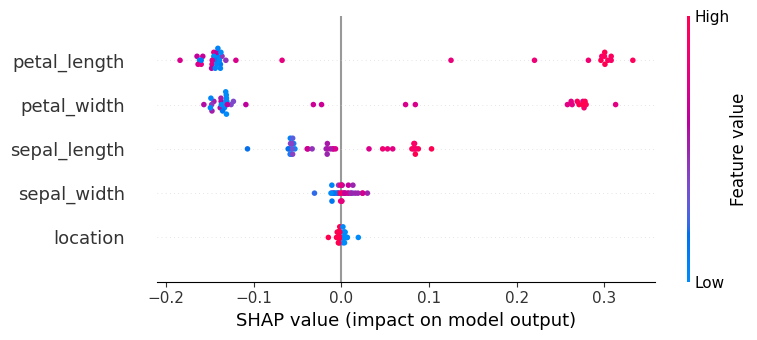

In [30]:

# 5a) SHAP summary plot for 'virginica'
shap.summary_plot(shap_values[:,:,virginica_idx], X_test_processed, feature_names=feature_names, show=True)


/var/tmp/ipykernel_3171372/2577858048.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,virginica_idx], X_test_processed, feature_names=feature_names, plot_type="bar", show=True)


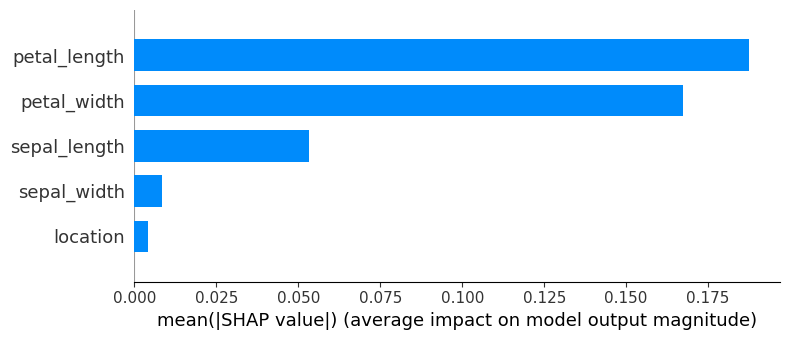

In [31]:

# 5b) Mean absolute SHAP value bar plot for 'virginica'
shap.summary_plot(shap_values[:,:,virginica_idx], X_test_processed, feature_names=feature_names, plot_type="bar", show=True)


In [ ]:

# 5c) Optional: dependence plot for the most important feature
# Uncomment to explore individual relationships
# shap.dependence_plot(0, shap_values[virginica_idx], X_test_processed, feature_names=feature_names, interaction_index=None, show=True)



## 6) Interpreting the SHAP plots (for `virginica`)

- **What the summary plot shows:** Each dot is one test-row. The position on the x-axis is how much that row's feature value **pushes** the model **toward** (`+`) or **away from** (`-`) predicting **virginica**. The color reflects whether the original feature value was **high** (red) or **low** (blue).
- **Reading importance:** Features at the **top** are generally the most influential across the dataset (larger spread in SHAP values).
- **Directionality:** If red dots for a feature tend to be on the **positive** (right) side, **higher** values of that feature push predictions **toward virginica**. If red dots sit left, higher values push **away** from virginica.
- **Bar plot (mean |SHAP|):** Ranks features by average impact magnitude on the virginica score, regardless of pushing direction.

For Iris, you’ll typically see **petal length/width** dominate decisions for `virginica` vs others. If `location` appears high, it means the model is **using** it; that could be a fairness concern if it’s not ethically acceptable or legally allowed.
